# Trabalho A2 - Banco de Dados
## Tema : UFC Lutas
#### Link  Base de Dados : https://www.kaggle.com/mdabbert/ultimate-ufc-dataset?select=ufc-master.csv

### Alunos: Germano Andrade e João Alcindo

In [1]:
import time
import datetime
import sqlite3

from datetime import date
import os
import random
import math

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import networkx as nx
from pyvis import network as net


from SPARQLWrapper import SPARQLWrapper, JSON    #sudo pip3 install --upgrade SPARQLWrapper

from IPython.display import display, Image
from IPython.core.interactiveshell import InteractiveShell

%matplotlib inline

# Representação do Banco de Dados:

![UFC_Schema](./Images/UFC_Schema_1.png)

In [2]:
conn = sqlite3.connect('UFC_lutas.db')
cur = conn.cursor()

In [3]:
with open("./Dump/query_juntar_dataframe.sql", 'r', encoding="UTF-8") as sql_query:
    query = sql_query.read()

A query feita para juntar o banco vai ser essa:
```sql
SELECT ft_w.name AS "Winner",
       ft_l.name AS "Loser", 
       SUBSTR(f.date, 1, 10) AS "date", 
       SUBSTR(f.date, 1, 4) AS "year", 
       l.city || ", " || l.state || ", " || l.country AS "location", 
       l.country AS "country", 
       f.title_bout AS "title_bout", 
       wc.name AS "weight_class", 
       ft_w.gender AS "gender", 
       SUBSTR(f.date, 1, 4) - ft_w.born_year AS "W_age", 
       SUBSTR(f.date, 1, 4) - ft_l.born_year AS "L_age", 
       ft_w.titles as "W_titles", 
       ft_l.titles as "L_titles" 
FROM fight as f INNER JOIN fighters as ft_w ON f.id_winner = ft_w.id_fighters 
INNER JOIN fighters AS ft_l ON f.id_loser = ft_l.id_fighters
INNER JOIN location AS l ON f.id_location = l.id_location
INNER JOIN weight_class as wc ON f.id_weight_class = wc.id_weight_class
ORDER BY f.id_fight;
```

In [4]:
df_ori = pd.read_sql_query(query, conn)

In [5]:
conn.commit()
conn.close()

In [6]:
df_ori.head()

,Winner,Loser,date,year,location,country,title_bout,weight_class,gender,W_age,L_age,W_titles,L_titles
0,Glover Teixeira,Thiago Santos,2020-11-07,2020,"Las Vegas, Nevada, USA",USA,0,Light Heavyweight,MALE,41,36,1,1
1,Andrei Arlovski,Tanner Boser,2020-11-07,2020,"Las Vegas, Nevada, USA",USA,0,Heavyweight,MALE,41,29,5,0
2,Raoni Barcelos,Khalid Taha,2020-11-07,2020,"Las Vegas, Nevada, USA",USA,0,Bantamweight,MALE,33,28,0,0
3,Yan Xiaonan,Claudia Gadelha,2020-11-07,2020,"Las Vegas, Nevada, USA",USA,0,Women's Strawweight,FEMALE,31,31,0,1
4,Trevin Giles,Bevon Lewis,2020-11-07,2020,"Las Vegas, Nevada, USA",USA,0,Middleweight,MALE,28,29,0,0


In [7]:
chosen = ['tomato', 
          'yellowgreen',
          'lime', 
          'mediumturquoise', 
          'cyan', 
          'cornflowerblue', 
          'pink', 
          'sandybrown', 
          'violet', 
          'khaki', 
          'darkorange', 
          'mediumorchid', 
          'springgreen']

color_class = dict(zip(df_ori['weight_class'].unique(),chosen))
color_class
#mcolors.cnames.keys()

{'Light Heavyweight': 'tomato',
 'Heavyweight': 'yellowgreen',
 'Bantamweight': 'lime',
 "Women's Strawweight": 'mediumturquoise',
 'Middleweight': 'cyan',
 'Featherweight': 'cornflowerblue',
 'Welterweight': 'pink',
 'Lightweight': 'sandybrown',
 "Women's Flyweight": 'violet',
 'Catch Weight': 'khaki',
 "Women's Bantamweight": 'darkorange',
 'Flyweight': 'mediumorchid',
 "Women's Featherweight": 'springgreen'}

In [8]:
df_ori["color_class"] = [color_class[i] for i in df_ori["weight_class"]]

df_ori[["title_bout", "W_age", "L_age", 
        "W_titles", "L_titles"]] = df_ori[["title_bout", "W_age", "L_age", 
                                                                           "W_titles", "L_titles"]].astype(float)

df_ori.head(5)

,Winner,Loser,date,year,location,country,title_bout,weight_class,gender,W_age,L_age,W_titles,L_titles,color_class
0,Glover Teixeira,Thiago Santos,2020-11-07,2020,"Las Vegas, Nevada, USA",USA,0.0,Light Heavyweight,MALE,41.0,36.0,1.0,1.0,tomato
1,Andrei Arlovski,Tanner Boser,2020-11-07,2020,"Las Vegas, Nevada, USA",USA,0.0,Heavyweight,MALE,41.0,29.0,5.0,0.0,yellowgreen
2,Raoni Barcelos,Khalid Taha,2020-11-07,2020,"Las Vegas, Nevada, USA",USA,0.0,Bantamweight,MALE,33.0,28.0,0.0,0.0,lime
3,Yan Xiaonan,Claudia Gadelha,2020-11-07,2020,"Las Vegas, Nevada, USA",USA,0.0,Women's Strawweight,FEMALE,31.0,31.0,0.0,1.0,mediumturquoise
4,Trevin Giles,Bevon Lewis,2020-11-07,2020,"Las Vegas, Nevada, USA",USA,0.0,Middleweight,MALE,28.0,29.0,0.0,0.0,cyan


### Descrição do Dataframe:

|Coluna|Tipo|Descrição|  
|:-|:-|:-|
|**Winner**|varchar(45)| Vencedor da luta|  
|**Loser**|varchar(45)| Perdedor da luta|   
|**date**|datetime| Dia da luta|   
|**location**|varchar(45)| Cidade, Estado e país onde ocorreu a luta|   
|**country**|varchar(30)|  País em que a luta ocorreu|  
|**title_bout**|boolean| Indica se a luta valia disputa de cinturão ou não|   
|**weight_class**|varchar(25)|  Categoria de peso|  
|**gender**|varchar(10)|  Gênero dos lutadores|  
|**W_age**|decimal(3,1)|  Idade do vencedor|  
|**L_age**|decimal(3,1)|  Idade do perdedor|  
|**W_titles**|decimal(,1)| Quantidade de títulos do vencedor|
|**L_titles**|decimal(,1)| Quantidade de títulos do vencedor|
|**year**|int(4)| Ano em que ocorreu a luta|
|**color**|varchar(20)| Cor relativa à classe de peso da luta|

## Criando uma função para gerar os grafos.

In [9]:
def create_graph(df):
    G = nx.DiGraph()
    #add nodes
    for idx in df.index:
        if df.loc[idx,'Winner'] not in G:
            G.add_node(df.loc[idx,'Winner'],
                       frequency=1,
                       gender = df.loc[idx, 'gender'], 
                       age = df.loc[idx, 'W_age'],
                       bouts = df.loc[idx, 'W_titles'],
                       border_color = 'gold' if df.loc[idx, 'W_titles'] else 'white',
                       color = df.loc[idx, 'color_class'])
        else:
            G.nodes[df.loc[idx,'Winner']]['frequency'] +=1

        if df.loc[idx,'Loser'] not in G:
            G.add_node(df.loc[idx,'Loser'],
                       frequency=1,
                       gender = df.loc[idx, 'gender'], 
                       age = df.loc[idx, 'L_age'],
                       bouts = df.loc[idx, 'L_titles'],
                       border_color = 'gold' if df.loc[idx, 'L_titles'] else 'white',
                       color = df.loc[idx, 'color_class'],
                       group = df.loc[idx, 'weight_class'])



    for idx in df.index:
        #if not G.has_edge(df.loc[idx,'Loser'], df.loc[idx,'Winner']):
        G.add_edge(df.loc[idx,'Loser'],
                   df.loc[idx,'Winner'], 
                   frequency = 1,
                   weight_class = df.loc[idx, 'weight_class'],
                   gender = df.loc[idx, 'gender'],
                   location = df.loc[idx, 'location'], 
                   title_bout = df.loc[idx, 'title_bout'],
                   year = df.loc[idx, 'year'], 
                   color = 'crimson' if df.loc[idx, 'title_bout'] else 'lightblue')#Colorir a aresta se a luta foi valendo título.
        #else:
         #   G.edges[df.loc[idx,'Loser'],df.loc[idx,'Winner']]['frequency'] += 1
    return G

## Criando uma função para exportar o grafo para html

In [10]:
def export_html(G, filename):
    g = net.Network("35em", "83em",notebook=False, directed= True)
    g.from_nx(G)
    #g.show_buttons(filter_=['physics'])
    g.show(filename)

## Primeiro grafo: Todas as lutas no ano de 2010

Number of fighters: 253
Number of fights: 209


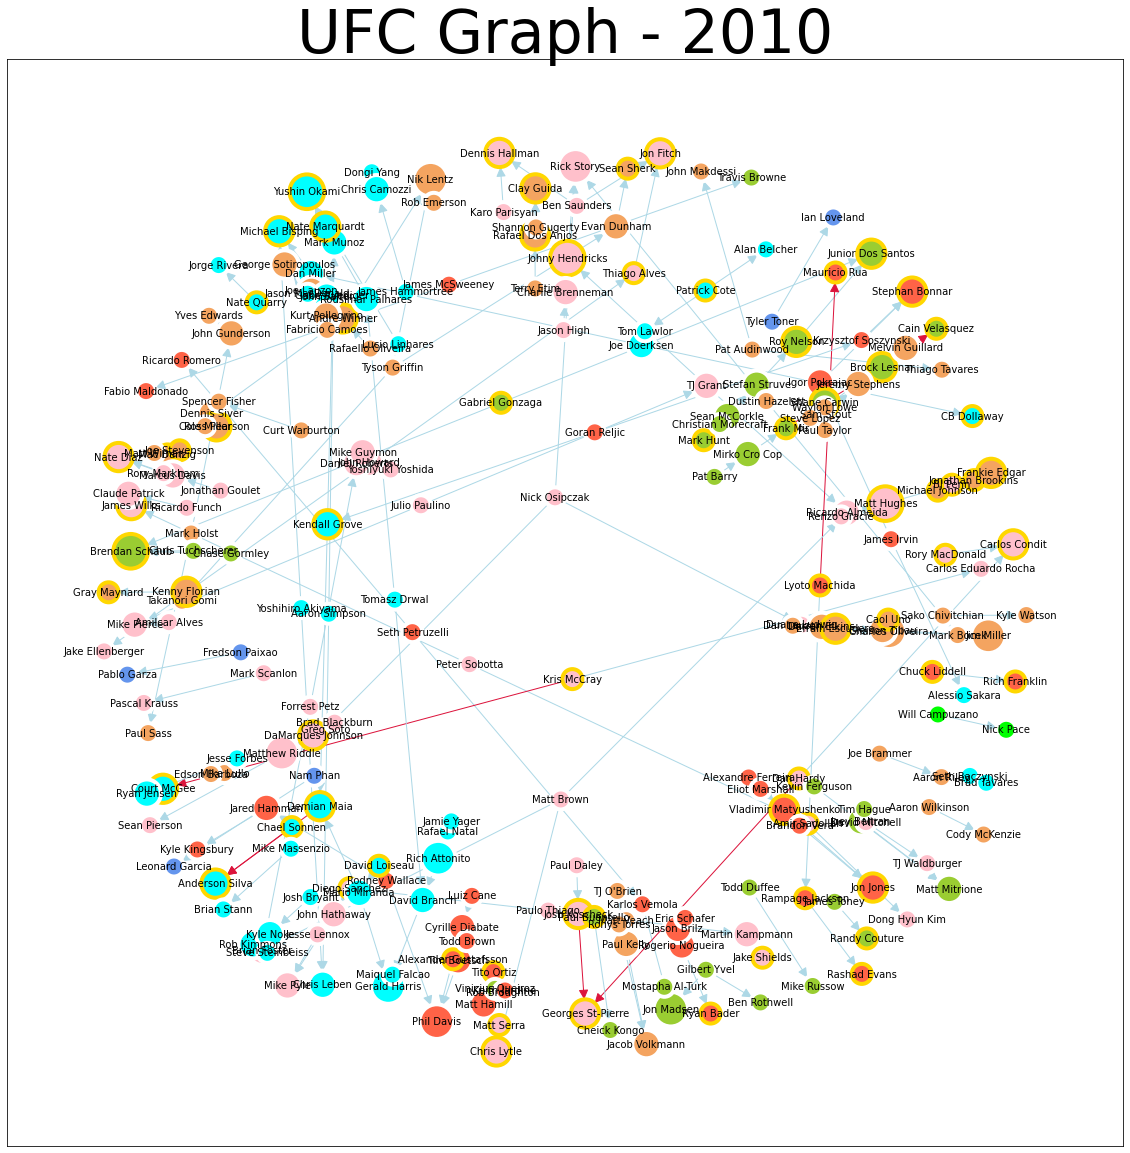

In [11]:
#Escolhendo o ano de 2010
df = df_ori[df_ori['year']=='2010']

G = create_graph(df)

#nx.draw_networkx(G)

print('Number of fighters: {}'.format(G.number_of_nodes()))
print('Number of fights: {}'.format(G.number_of_edges()))

#Desenhando o grafo
SG = nx.DiGraph((u,v,d) for u,v,d in G.edges(data=True) if d['year'] == '2010')

fig, ax = plt.subplots(figsize=(20,20))
ax.set_title("UFC Graph - 2010", fontdict={'fontsize': 60, 'fontweight': 'medium'})
pos = nx.spring_layout(SG, seed=2020)

nx.draw_networkx(SG,
                node_size=[400*nx.get_node_attributes(G,'frequency')[g] for g in SG.nodes()],
                pos = pos,
                #width=list(nx.get_edge_attributes(SG,'frequency').values()),
                edge_cmap=None,
                arrowsize = 20,
                linewidths = 4,
                edge_vmin=None,
                edge_vmax=None,
                node_color = [nx.get_node_attributes(G,'color')[g] for g in SG.nodes()], 
                edge_color = [nx.get_edge_attributes(SG,'color')[g] for g in SG.edges()],#"lightblue",
                style='solid',
                labels=None ,
                font_size=10,
                #font_color='blue',
                font_weight='normal',
                font_family='sans-serif',
                label='UFCGraph',
                edgecolors = [nx.get_node_attributes(G,'border_color')[g] for g in SG.nodes()])

name = './Results/UFC_Graph-2010'
plt.savefig(name+".png")
export_html(G, name+".html")

## Segundo grafo: Lutas de peso médio no ano de 2019

Number of fighters: 54
Number of fights: 45


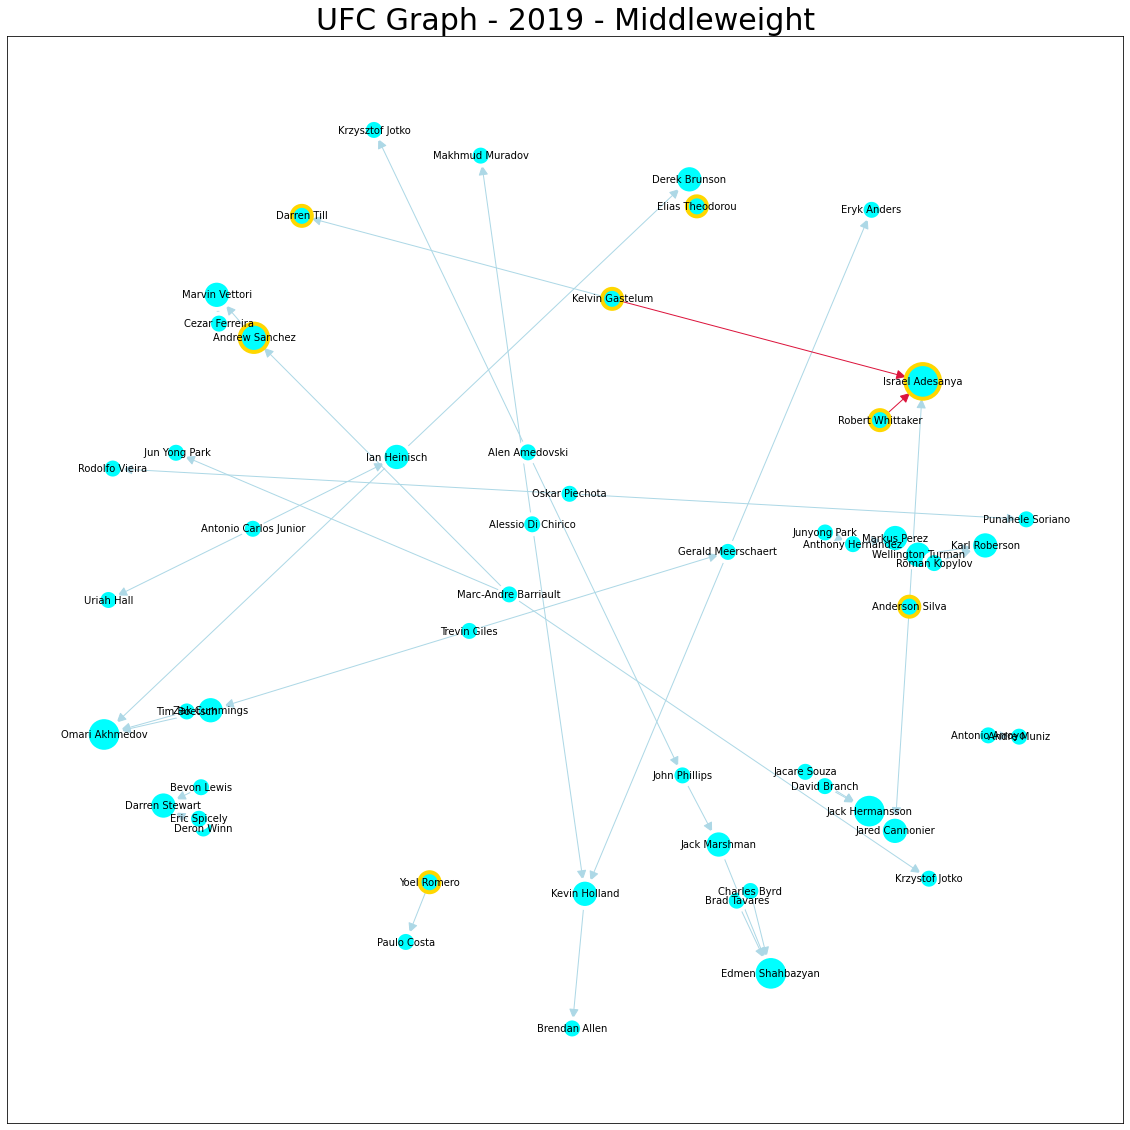

In [12]:
df = df_ori[(df_ori["year"]=='2019') & (df_ori['weight_class'] == 'Middleweight')]

G = create_graph(df)

#Desenhando o grafo
#SG = nx.DiGraph((u,v,d) for u,v,d in G.edges(data=True) if d['weight_class'] == 'Middleweight')

print('Number of fighters: {}'.format(G.number_of_nodes()))
print('Number of fights: {}'.format(G.number_of_edges()))

fig, ax = plt.subplots(figsize=(20,20))
ax.set_title("UFC Graph - 2019 - Middleweight", fontdict={'fontsize': 30, 'fontweight': 'medium'})
pos = nx.spring_layout(G, seed=2020)

nx.draw_networkx(G,
                node_size=[400*nx.get_node_attributes(G,'frequency')[g] for g in G.nodes()],
                pos = pos,
                #width=list(nx.get_edge_attributes(SG,'frequency').values()),
                edge_cmap=None,
                arrowsize = 20,
                linewidths = 4,
                edge_vmin=None,
                edge_vmax=None,
                node_color = [nx.get_node_attributes(G,'color')[g] for g in G.nodes()], 
                edge_color = [nx.get_edge_attributes(G,'color')[g] for g in G.edges()],#"lightblue",
                style='solid',
                labels=None ,
                font_size=10,
                #font_color='blue',
                font_weight='normal',
                font_family='sans-serif',
                label='UFCGraph',
                edgecolors = [nx.get_node_attributes(G,'border_color')[g] for g in G.nodes()])

name = './Results/UFC_Graph-2019 - Middleweight'
plt.savefig(name+".png")
export_html(G, name+".html")

## Terceiro grafo: Lutas em 2020 - Feminino

Number of fighters: 98
Number of fights: 70


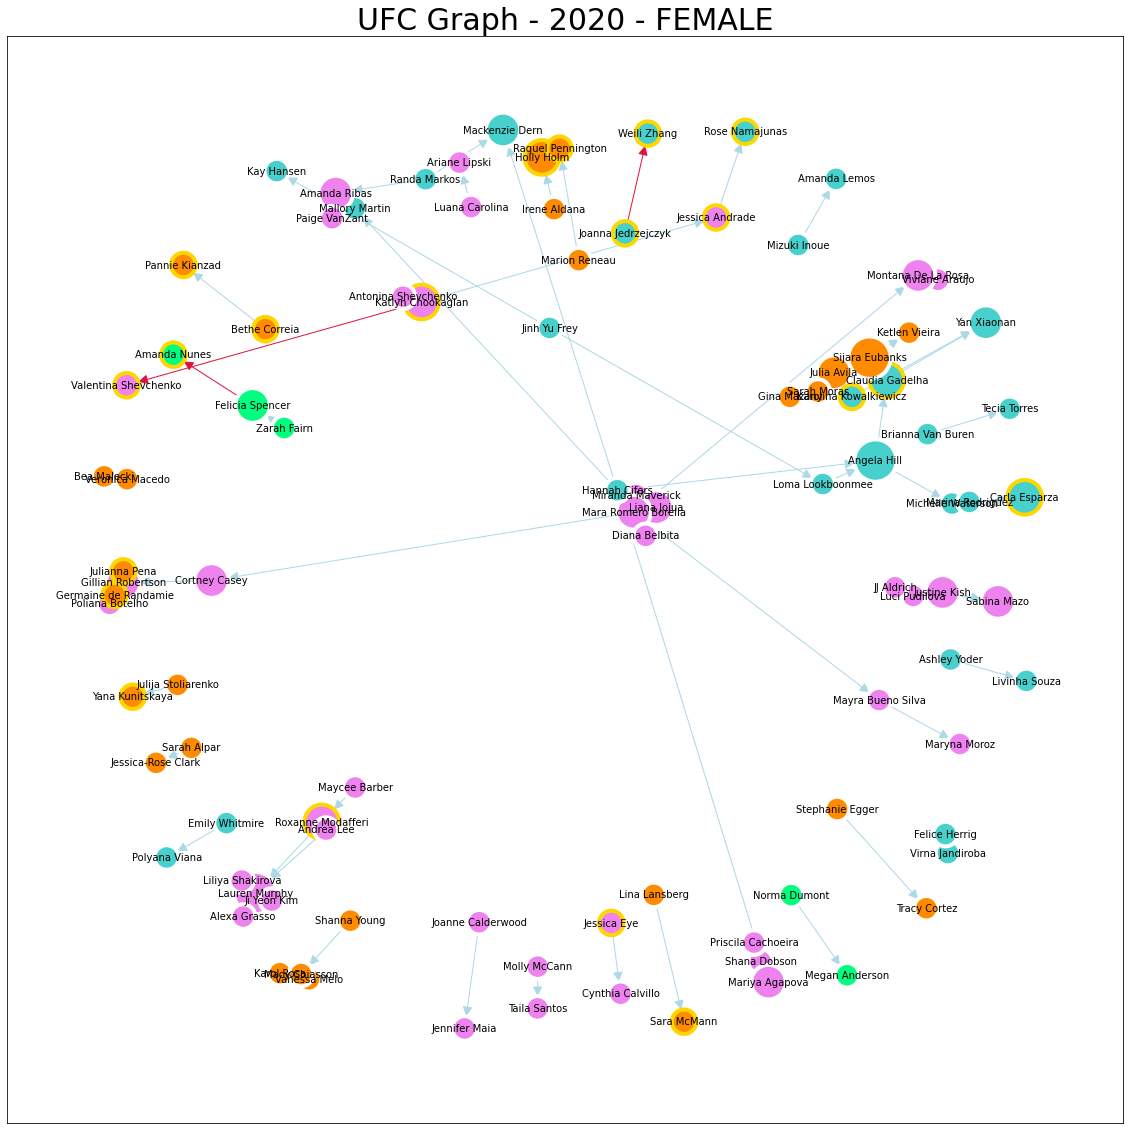

In [13]:
df = df_ori[(df_ori["year"]=='2020') & (df_ori['gender'] == 'FEMALE')]
G = create_graph(df)

#Desenhando o grafo
#SG = nx.DiGraph((u,v,d) for u,v,d in G.edges(data=True) if d['gender'] == 'FEMALE')

print('Number of fighters: {}'.format(G.number_of_nodes()))
print('Number of fights: {}'.format(G.number_of_edges()))

fig, ax = plt.subplots(figsize=(20,20))
ax.set_title("UFC Graph - 2020 - FEMALE", fontdict={'fontsize': 30, 'fontweight': 'medium'})
pos = nx.spring_layout(G, seed=2020)

nx.draw_networkx(G,
                node_size=[600*nx.get_node_attributes(G,'frequency')[g] for g in G.nodes()],
                pos = pos,
                #width=list(nx.get_edge_attributes(SG,'frequency').values()),
                edge_cmap=None,
                arrowsize = 20,
                linewidths = 4,
                edge_vmin=None,
                edge_vmax=None,
                node_color = [nx.get_node_attributes(G,'color')[g] for g in G.nodes()], 
                edge_color = [nx.get_edge_attributes(G,'color')[g] for g in G.edges()],#"lightblue",
                style='solid',
                labels=None ,
                font_size=10,
                #font_color='blue',
                font_weight='normal',
                font_family='sans-serif',
                label='UFCGraph',
                edgecolors = [nx.get_node_attributes(G,'border_color')[g] for g in G.nodes()])

name = './Results/UFC_Graph 2020 - FEMALE'
plt.savefig(name+".png")
export_html(G, name+".html")

## Quarto grafo(s): diferença entre quantidade de lutas femininas e masculinas no Brasil

### Brasil - Lutas femininas

Number of fighters: 48
Number of fights: 30


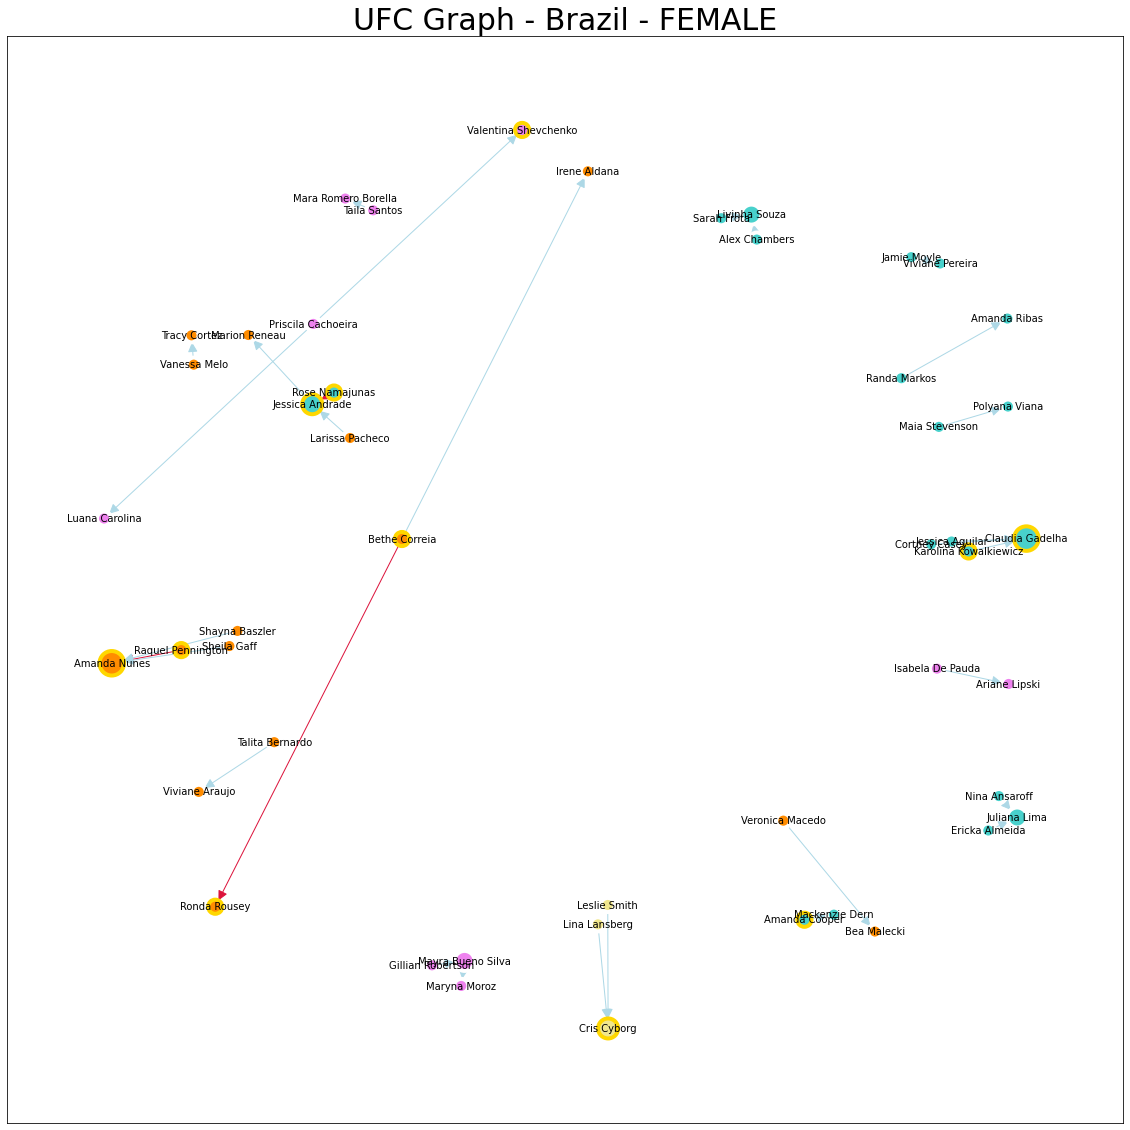

In [14]:
df = df_ori[(df_ori["country"]=='Brazil') & (df_ori['gender'] == 'FEMALE')]
G = create_graph(df)

#Desenhando o grafo
#SG = nx.DiGraph((u,v,d) for u,v,d in G.edges(data=True) if d['gender'] == 'FEMALE')

print('Number of fighters: {}'.format(G.number_of_nodes()))
print('Number of fights: {}'.format(G.number_of_edges()))

fig, ax = plt.subplots(figsize=(20,20))
ax.set_title("UFC Graph - Brazil - FEMALE", fontdict={'fontsize': 30, 'fontweight': 'medium'})
pos = nx.spring_layout(G, seed=2020)

nx.draw_networkx(G,
                node_size=[200*nx.get_node_attributes(G,'frequency')[g] for g in G.nodes()],
                pos = pos,
                #width=list(nx.get_edge_attributes(SG,'frequency').values()),
                edge_cmap=None,
                arrowsize = 20,
                linewidths = 4,
                edge_vmin=None,
                edge_vmax=None,
                node_color = [nx.get_node_attributes(G,'color')[g] for g in G.nodes()], 
                edge_color = [nx.get_edge_attributes(G,'color')[g] for g in G.edges()],#"lightblue",
                style='solid',
                labels=None ,
                font_size=10,
                #font_color='blue',
                font_weight='normal',
                font_family='sans-serif',
                label='UFCGraph',
                edgecolors = [nx.get_node_attributes(G,'border_color')[g] for g in G.nodes()])

name = './Results/UFC_Graph - Brazil - FEMALE'
plt.savefig(name+".png")
export_html(G, name+".html")

### Brasil - Lutas Masculinas

Number of fighters: 398
Number of fights: 379


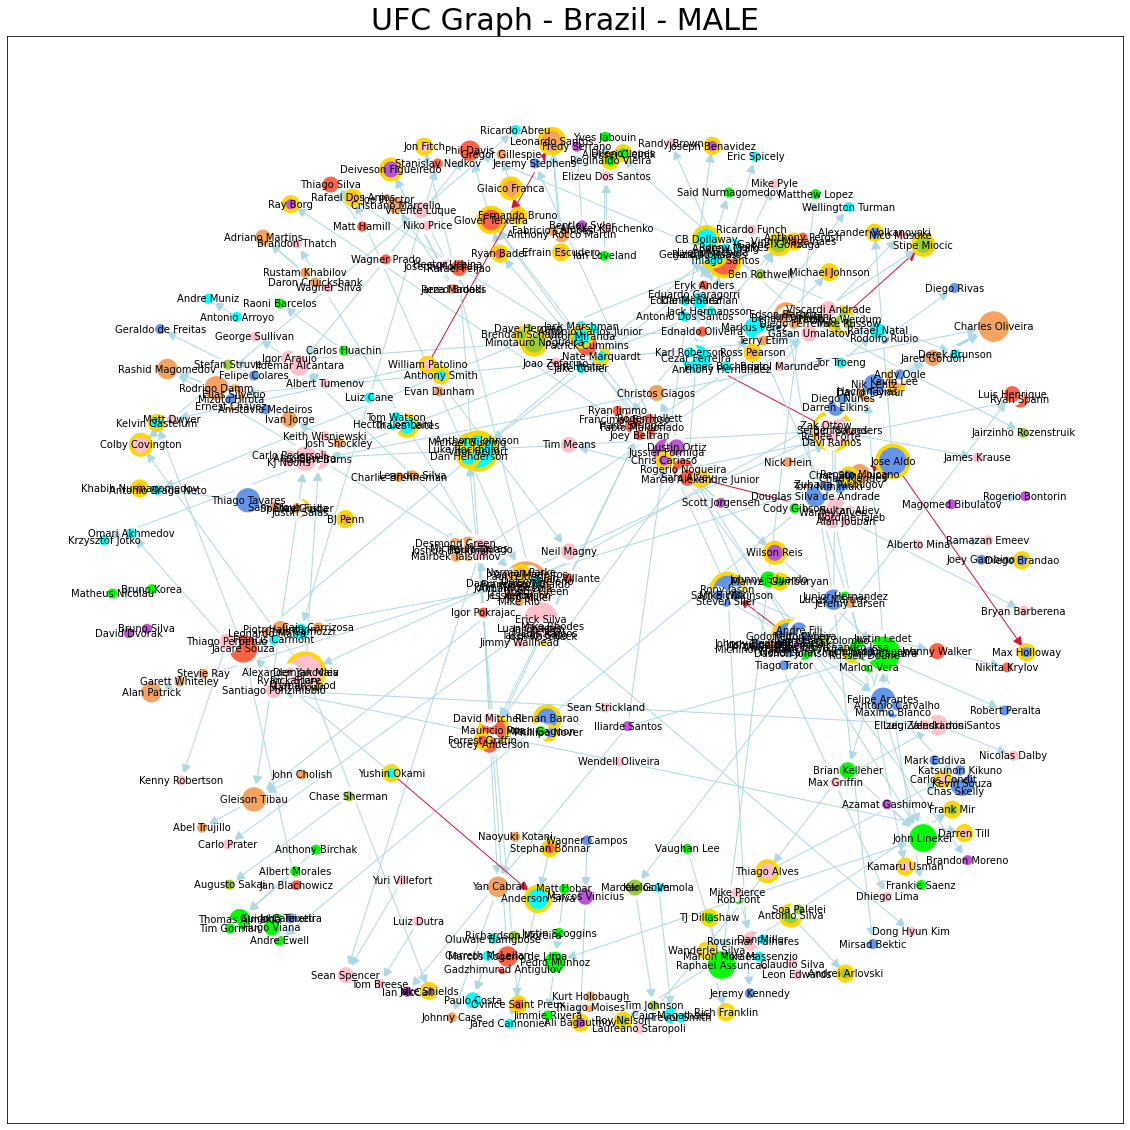

In [15]:
df = df_ori[(df_ori["country"]=='Brazil') & (df_ori['gender'] == 'MALE')]
G = create_graph(df)

#Desenhando o grafo
#SG = nx.DiGraph((u,v,d) for u,v,d in G.edges(data=True) if d['gender'] == 'MALE')

print('Number of fighters: {}'.format(G.number_of_nodes()))
print('Number of fights: {}'.format(G.number_of_edges()))

fig, ax = plt.subplots(figsize=(20,20))
ax.set_title("UFC Graph - Brazil - MALE", fontdict={'fontsize': 30, 'fontweight': 'medium'})
pos = nx.spring_layout(G, seed=2020)

nx.draw_networkx(G,
                node_size=[200*nx.get_node_attributes(G,'frequency')[g] for g in G.nodes()],
                pos = pos,
                #width=list(nx.get_edge_attributes(SG,'frequency').values()),
                edge_cmap=None,
                arrowsize = 20,
                linewidths = 4,
                edge_vmin=None,
                edge_vmax=None,
                node_color = [nx.get_node_attributes(G,'color')[g] for g in G.nodes()], 
                edge_color = [nx.get_edge_attributes(G,'color')[g] for g in G.edges()],#"lightblue",
                style='solid',
                labels=None ,
                font_size=10,
                #font_color='blue',
                font_weight='normal',
                font_family='sans-serif',
                label='UFCGraph',
                edgecolors = [nx.get_node_attributes(G,'border_color')[g] for g in G.nodes()])

name = './Results/UFC_Graph - Brazil - MALE'
plt.savefig(name+".png")
export_html(G, name+".html")

### Quinto grafo: Lutas valendo título

Number of fighters: 204
Number of fights: 202


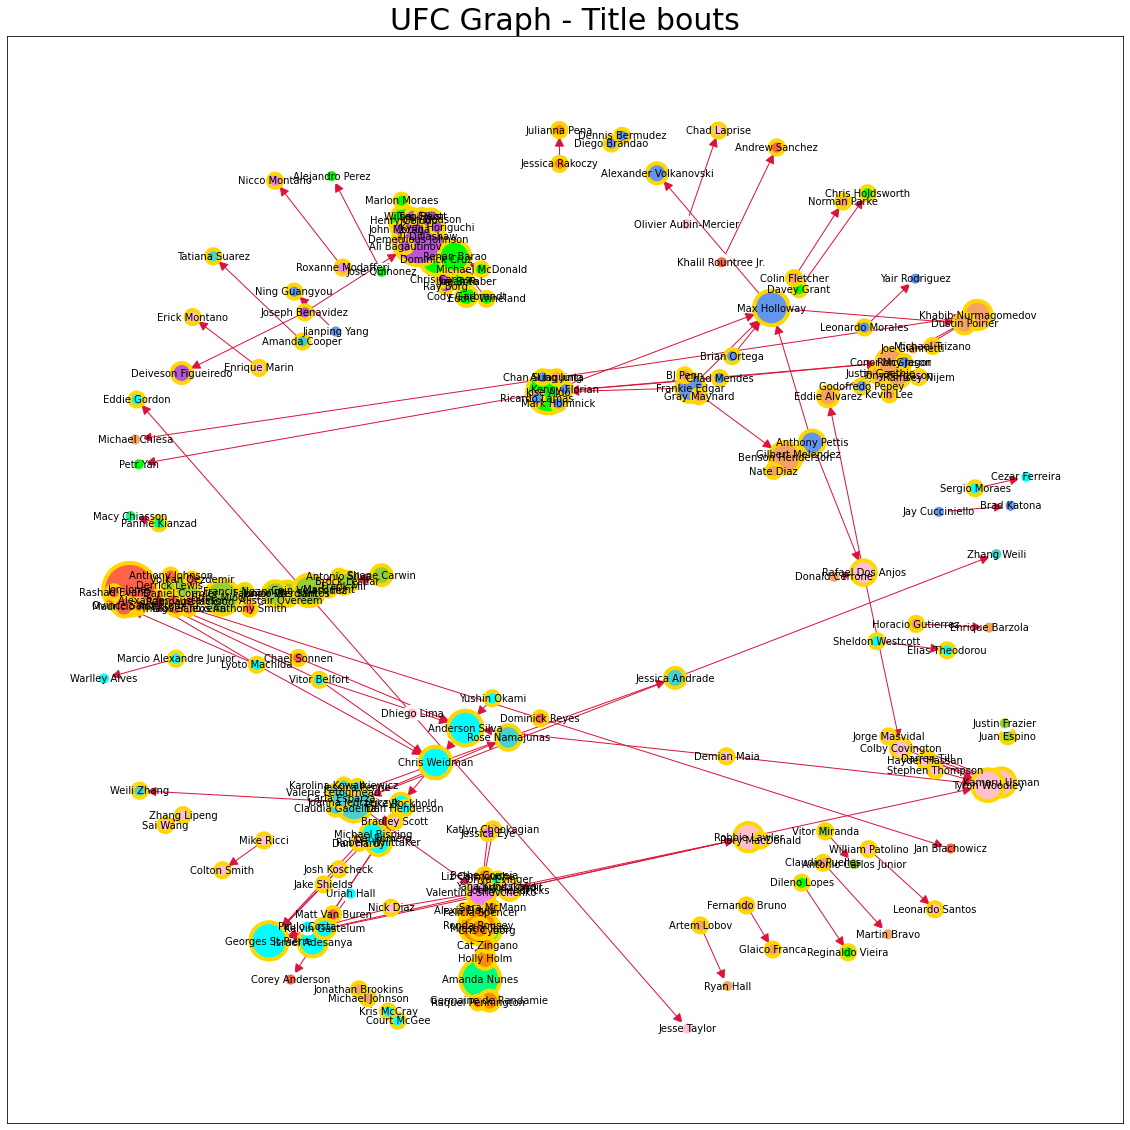

In [16]:
df = df_ori[df_ori["title_bout"]==1]
G = create_graph(df)

#Desenhando o grafo
#SG = nx.DiGraph((u,v,d) for u,v,d in G.edges(data=True) if d['gender'] == 'MALE')

print('Number of fighters: {}'.format(G.number_of_nodes()))
print('Number of fights: {}'.format(G.number_of_edges()))

fig, ax = plt.subplots(figsize=(20,20))
ax.set_title("UFC Graph - Title bouts", fontdict={'fontsize': 30, 'fontweight': 'medium'})
pos = nx.spring_layout(G, seed=2020)

nx.draw_networkx(G,
                node_size=[200*nx.get_node_attributes(G,'frequency')[g] for g in G.nodes()],
                pos = pos,
                #width=list(nx.get_edge_attributes(SG,'frequency').values()),
                edge_cmap=None,
                arrowsize = 20,
                linewidths = 4,
                edge_vmin=None,
                edge_vmax=None,
                node_color = [nx.get_node_attributes(G,'color')[g] for g in G.nodes()], 
                edge_color = [nx.get_edge_attributes(G,'color')[g] for g in G.edges()],#"lightblue",
                style='solid',
                labels=None ,
                font_size=10,
                #font_color='blue',
                font_weight='normal',
                font_family='sans-serif',
                label='UFCGraph',
                edgecolors = [nx.get_node_attributes(G,'border_color')[g] for g in G.nodes()])

name = './Results/UFC_Graph - Title Bouts'
plt.savefig(name+".png")
export_html(G, name+".html")

### Sexto grafo: Ganhador ou Perdedor tem no mínimo 10 títulos.

Number of fighters: 86
Number of fights: 91


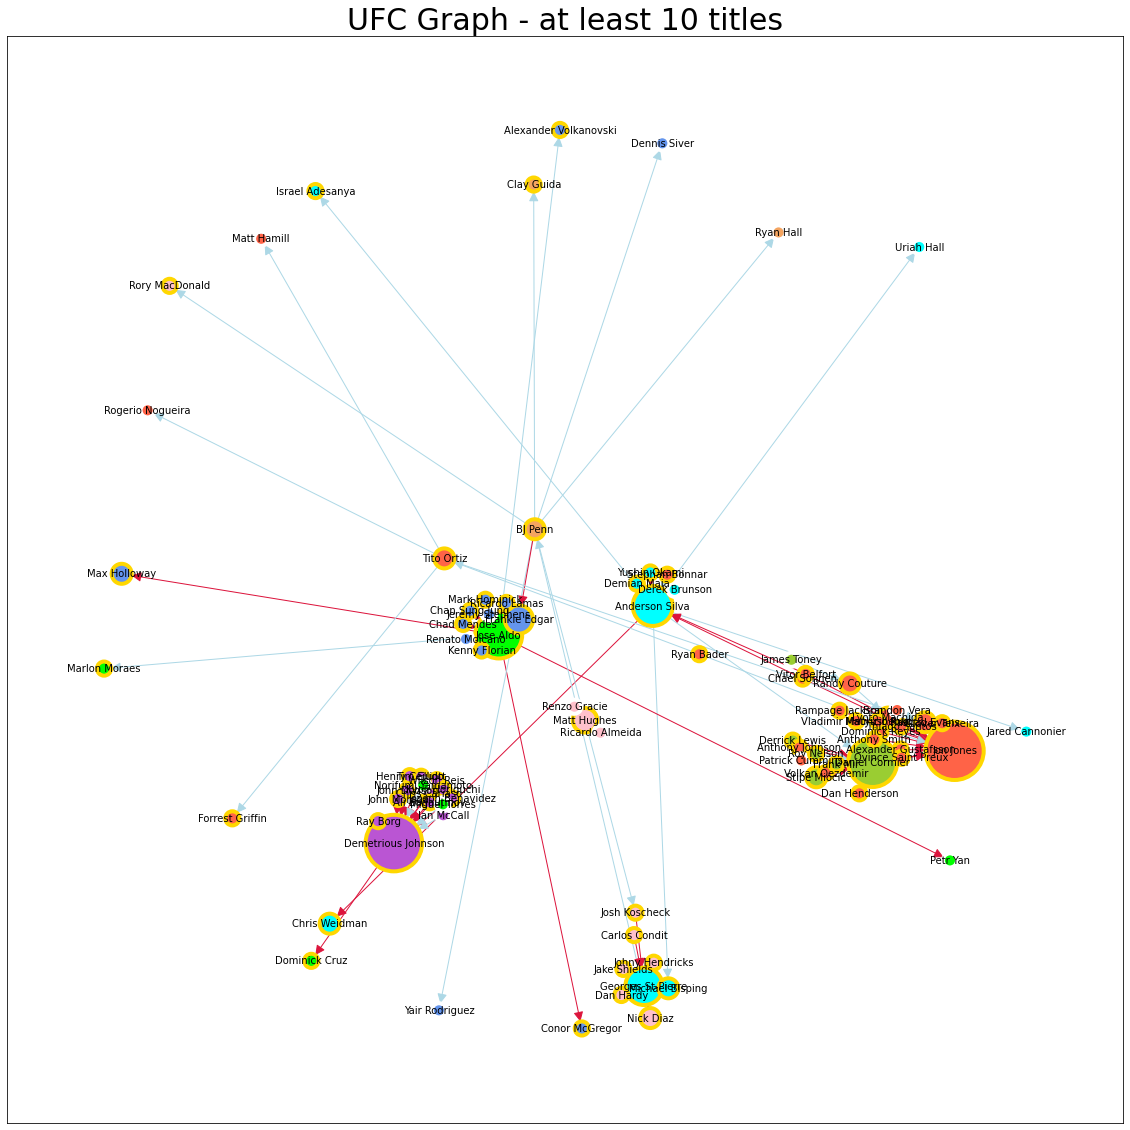

In [17]:
df = df_ori[(df_ori["W_titles"]>=10) | (df_ori["L_titles"]>=10)]

G = create_graph(df)

#Desenhando o grafo
#SG = nx.DiGraph((u,v,d) for u,v,d in G.edges(data=True) if d['gender'] == 'MALE')

print('Number of fighters: {}'.format(G.number_of_nodes()))
print('Number of fights: {}'.format(G.number_of_edges()))

fig, ax = plt.subplots(figsize=(20,20))
ax.set_title("UFC Graph - at least 10 titles", fontdict={'fontsize': 30, 'fontweight': 'medium'})
pos = nx.spring_layout(G, seed=2020)

nx.draw_networkx(G,
                node_size=[200*nx.get_node_attributes(G,'frequency')[g] for g in G.nodes()],
                pos = pos,
                #width=list(nx.get_edge_attributes(SG,'frequency').values()),
                edge_cmap=None,
                arrowsize = 20,
                linewidths = 4,
                edge_vmin=None,
                edge_vmax=None,
                node_color = [nx.get_node_attributes(G,'color')[g] for g in G.nodes()], 
                edge_color = [nx.get_edge_attributes(G,'color')[g] for g in G.edges()],#"lightblue",
                style='solid',
                labels=None ,
                font_size=10,
                #font_color='blue',
                font_weight='normal',
                font_family='sans-serif',
                label='UFCGraph',
                edgecolors = [nx.get_node_attributes(G,'border_color')[g] for g in G.nodes()])

name = './Results/UFC_Graph - at least 10 titles'
plt.savefig(name+".png")
export_html(G, name+".html")